#1)a)Problem Statement and Significance


##Problem Statement
The objective of this project is to create a robust machine learning model capable of accurately classifying images depicting individuals engaged in either running or walking activities. The challenge lies in effectively distinguishing between these two closely related motions based on visual cues captured in images.

##Significance
This project holds substantial significance in various domains:

1. Fitness Monitoring: The developed model can be utilized to automatically monitor and analyze individuals' fitness activities, providing insights into their exercise routines and promoting healthier lifestyles.

2. Surveillance and Security: In surveillance applications, the ability to distinguish between running and walking individuals can enhance security systems, alerting authorities to potentially suspicious or abnormal behaviors.

3. Healthcare: Such a model could contribute to healthcare applications, assisting medical professionals in assessing patients' mobility and recovery progress remotely through images.

4. Human-Computer Interaction: The model can also be incorporated into human-computer interaction systems, enabling devices to respond differently based on users' motion patterns.

5. Research: The data collected and the model developed could also serve as valuable resources for researchers studying human locomotion, biomechanics, and activity recognition.

Addressing this problem holds the potential to impact multiple sectors, improving fitness tracking, security, healthcare, and technology interfaces, ultimately enhancing our understanding of human activities through image classification


# Mounting Google Drive and Importing required libraries

In [ ]:
# Import necessary libraries and modules
from google.colab import drive
drive.mount("/content/Drive")
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Base Path for all files
base_dir = '/content/Drive/MyDrive/Walk-or-Run/analysis/'
train_data_dir = '/content/Drive/MyDrive/Walk-or-Run/analysis/walk_or_run_train'
test_data_dir = '/content/Drive/MyDrive/Walk-or-Run/analysis/walk_or_run_test'


Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


#Q2) Data Collection and Preprocessing

Collection of Data Source:
The  dataset is collected from Google Images and utilizing pre-trained models such as ResNet50 and DenseNet from ImageNet.



These global variables ensure uniform data loading, preprocessing, and training settings; their values are determined through experimentation and best practices to optimize model performance and stability considering dataset characteristics, computational constraints, and model requirements.

In [ ]:
# Global Variables -- Constants
RESCALE = 1/255
TARGET_SIZE = (300, 300)
COLOR_MODE = "rgb"
CLASS_MODE = "categorical"
BATCH_SIZE = 32


1. RESCALE:

Purpose: This variable determines the scaling factor applied to pixel values in the image data.

Explanation: The value 1/255 is used as the scaling factor. It means that each pixel value in the image will be divided by 255 to bring it within the range of 0 to 1. This scaling is performed to ensure that pixel values are in a suitable range for deep learning models.
2. TARGET_SIZE:

Purpose: This variable defines the target size to which images will be resized during preprocessing.

Explanation: Images in the dataset are resized to the dimensions specified in TARGET_SIZE, which is (300, 300) in this case. Resizing images to a consistent size is important to ensure that all images have the same dimensions, making them suitable for model training.
3. COLOR_MODE:

Purpose: This variable specifies the color mode for loading images.

Explanation: The value "rgb" indicates that images will be loaded in RGB (Red, Green, Blue) color mode. Each pixel in the image has three color channels (RGB), and this color mode ensures that the images are loaded with these three color channels.
4. CLASS_MODE:

Purpose: This variable defines the class mode for loading images, which is relevant for multi-class classification tasks.

Explanation: The value "categorical" indicates that the dataset contains multiple classes, and each image is associated with one of these classes. The labels for each image will be encoded in a categorical format, where each class is represented by a binary vector.
5. BATCH_SIZE:

Purpose: This variable determines the number of samples processed in each batch during training and prediction.

Explanation: During training, the model updates its weights based on a batch of samples rather than processing the entire dataset at once. The batch size of 32 means that the model will process 32 images at a time and update its weights after each batch. Smaller batch sizes can lead to faster training but might have noisy updates, while larger batch sizes can provide more stable updates but might require more memory

In [ ]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "training_data": ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=RESCALE,
        validation_split=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=30
    ).flow_from_directory(
        directory=os.path.join(train_data_dir, "train"),
        target_size=TARGET_SIZE,
        color_mode=COLOR_MODE,
        class_mode=CLASS_MODE,
        batch_size=BATCH_SIZE,
        subset='training'
    ),

    "validation_data": ImageDataGenerator(
        rescale=RESCALE,
        validation_split=0.1,
    ).flow_from_directory(
        directory=os.path.join(train_data_dir, "train"),
        target_size=TARGET_SIZE,
        color_mode=COLOR_MODE,
        class_mode=CLASS_MODE,
        batch_size=BATCH_SIZE,
        subset='validation'
    ),

    "testing_data": ImageDataGenerator(
        rescale=RESCALE,
    ).flow_from_directory(
        directory=os.path.join(test_data_dir, "test"),
        target_size=TARGET_SIZE,
        color_mode=COLOR_MODE,
        class_mode=CLASS_MODE,
        batch_size=BATCH_SIZE,
    ),
}


Found 541 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


Training Data: 541 images belonging to 2 classes.

Validation Data: 59 images belonging to 2 classes.

Test Data:141 images belonging to 2 classes.

#Performing EDA


Since the code is focused on image data and deep learning, traditional Exploratory Data Analysis (EDA) might not be as applicable. However, we can add some visualizations to understand the distribution of classes in your training and testing datasets.

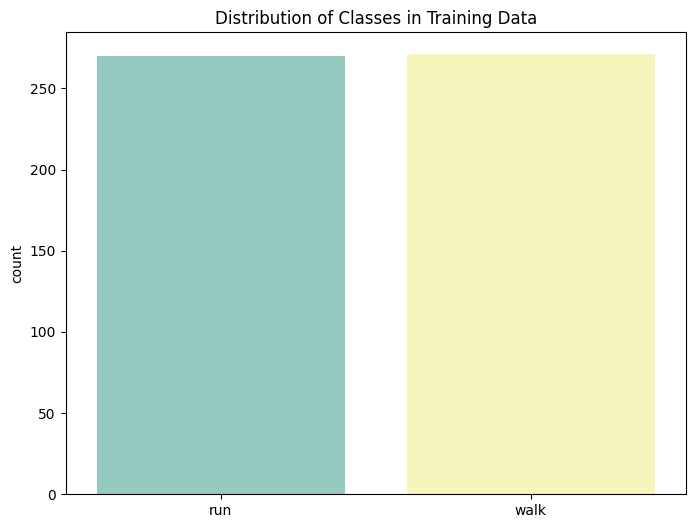

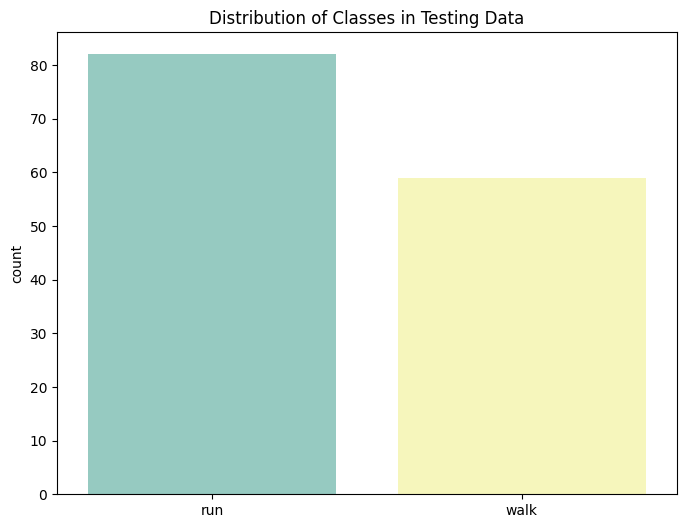

In [ ]:
#  Perform Exploratory Data Analysis (EDA)
train_labels = datagenerator["training_data"].classes
test_labels = datagenerator["testing_data"].classes
class_names = list(datagenerator["training_data"].class_indices.keys())

plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels, palette='Set3')
plt.title('Distribution of Classes in Training Data')
plt.xticks(range(2), class_names)
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=test_labels, palette='Set3')
plt.title('Distribution of Classes in Testing Data')
plt.xticks(range(2), class_names)
plt.show()

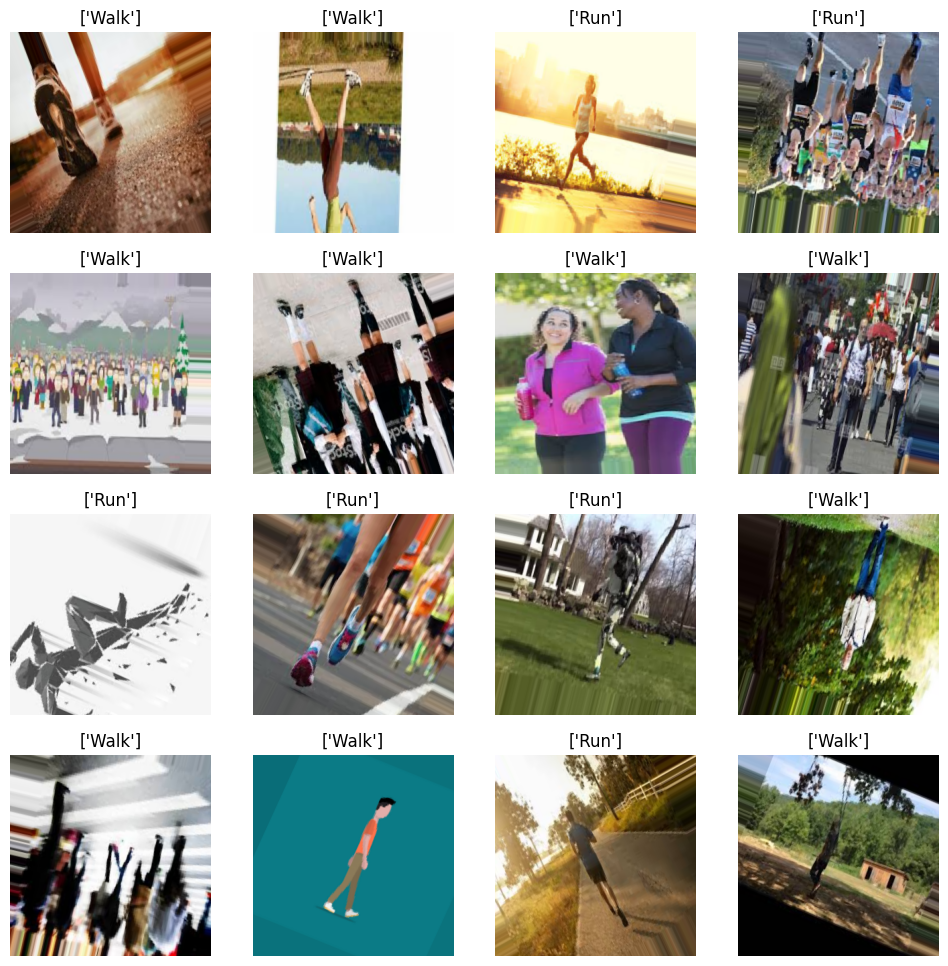

In [ ]:
# -- plot random batch --
images, labels = datagenerator["training_data"].next()
CLASSES = ['Run','Walk']
classes = np.asarray(CLASSES)

_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()

for img, l, ax in zip(images, labels, axs):
    ax.imshow(img)
    ax.axis('off')
    l = l.astype(int)
    ax.set_title(classes[l == 1])

plt.show()

#Identification of target variable
Looking at the Training Dataset we can see the images have classes assigned to either Walk or Run. We can see that the images represent Running or Walking, hence we will classify an image to be a walk or run.i.e, Target variable is to classify image as Walk or Run.

#Q3) Model Selection and Implementation

#Model 1
# CNN Model Using InceptionV3 architecture

#Why CNN?
The CNN InceptionV3 architecture is chosen for the run/walk image classifier due to its capacity to learn intricate features, pretrained weights from ImageNet for efficient transfer learning, and adaptability for specialized tasks. Its multi-scale feature extraction, deep contextual understanding, and experimental validation make it suitable for capturing nuanced differences between running and walking activities.

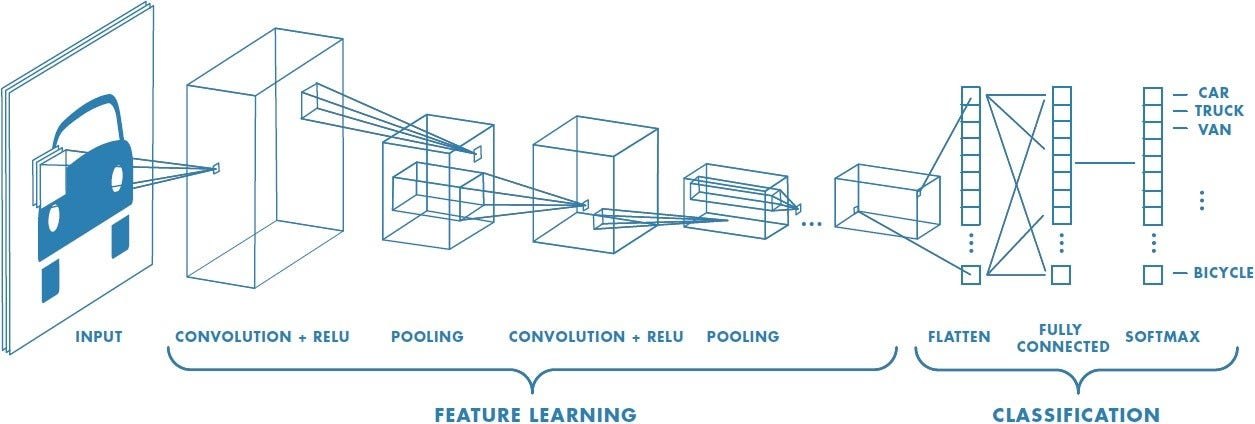

#Explaination of above diagram


In [ ]:
# Build a CNN model using InceptionV3 as base
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))
base_model.load_weights(os.path.join(base_dir, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'))

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

#Adding more layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])


# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 23,903,010
Trainable params: 2,100,226
Non-trainable params: 21,802,784
____________________________________

GlobalAveragePooling2D: This layer takes the output feature maps from the previous layer (in this case, the base_model) and computes the average value for each feature map. This reduces the spatial dimensions of the feature maps while retaining important information.

Dropout: Dropout is a regularization technique that randomly sets a fraction of the input units to 0 during each training iteration. This helps prevent overfitting by encouraging the network to not rely too much on any specific set of neurons.

Dense: This is a fully connected layer with 1024 units and a ReLU activation function. It's a way to add a non-linear transformation to the data.

Dense (Output Layer): This is the final layer with 2 units (assuming you have 2 classes). The activation function is softmax, which produces probability scores for each class, indicating the likelihood of the input belonging to that class.

Explanation: In this section, we're building a Sequential model with an InceptionV3 base (pretrained on ImageNet) followed by global average pooling, dropout, and dense layers. The model is compiled with a categorical cross-entropy loss function and an Adam optimizer. The model summary is displayed.

## Seperating Train and Test Data

In [20]:
# Set variables and data generators
epochs = 20

train_generator = datagenerator["training_data"]
valid_generator = datagenerator["validation_data"]
test_generator = datagenerator["testing_data"]

steps_per_epoch = train_generator.n // BATCH_SIZE
validation_steps = valid_generator.n // BATCH_SIZE

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 16
validation_steps : 1


Explanation: These variables and data generators are set for the training, validation, and testing steps. The number of steps per epoch is calculated based on the batch size.

#Implement checkpoints and initiate model training


In [21]:
filepath = os.path.join(base_dir, "CNN-Models", "model_{epoch:02d}-{val_accuracy:.2f}.h5")
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

history = model.fit_generator(
    generator=train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)


Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.7695
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to /content/Drive/MyDrive/Walk-or-Run/analysis/CNN-Models/model_01-0.62.h5
16/16 [==============================] - 94s 6s/step - loss: 0.4693 - accuracy: 0.7695 - val_loss: 0.7071 - val_accuracy: 0.6250
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.7741
Epoch 2: val_accuracy improved from 0.62500 to 0.84375, saving model to /content/Drive/MyDrive/Walk-or-Run/analysis/CNN-Models/model_02-0.84.h5
16/16 [==============================] - 94s 6s/step - loss: 0.4435 - accuracy: 0.7741 - val_loss: 0.3752 - val_accuracy: 0.8438
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.8035
Epoch 3: val_accuracy did not improve from 0.84375
16/16 [==============================] - 94s 6s/step - loss: 0.4140 - accuracy: 0.8035 - val_loss: 0.3534 - val_accuracy: 0.

Here, a model checkpoint is set up to save the best model based on validation accuracy. The model is trained using the fit_generator method.

In [22]:
# Evaluate your CNN model on the testing dataset
cnn_test_loss, cnn_test_acc = model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_test_acc)

5/5 [==============================] - 24s 4s/step - loss: 0.3791 - accuracy: 0.8156
CNN Test Accuracy: 0.8156028389930725


#Model 2: Logistic Regression with Default parameters

In [23]:
#Add Logistic Regression
train_features = base_model.predict(train_generator)
test_features = base_model.predict(test_generator)

train_features_flatten = train_features.reshape(train_features.shape[0], -1)
test_features_flatten = test_features.reshape(test_features.shape[0], -1)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_features_flatten, train_labels)
logreg_predictions = logreg.predict(test_features_flatten)

# Evaluate the  Logistic Regression with default parameters
print("Logistic Regression with default parameters:")
print(classification_report(test_labels, logreg_predictions))
print("Accuracy:", accuracy_score(test_labels, logreg_predictions))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, logreg_predictions))



5/5 [==============================] - 23s 4s/step
Logistic Regression with default parameters:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        82
           1       0.41      0.47      0.44        59

    accuracy                           0.49       141
   macro avg       0.49      0.49      0.48       141
weighted avg       0.50      0.49      0.49       141

Accuracy: 0.48936170212765956
Confusion Matrix:
[[41 41]
 [31 28]]


#Model 3: Random Forest with Default parameters

In [24]:
rf_classifier = RandomForestClassifier(random_state=245)
rf_classifier.fit(train_features_flatten, train_labels)
rf_predictions = rf_classifier.predict(test_features_flatten)

# Evaluate the  Random Forest model with default parameters
print("\nRandom Forest with default parameters::")
print(classification_report(test_labels, rf_predictions))
print("Accuracy:", accuracy_score(test_labels, rf_predictions))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, rf_predictions))


Random Forest with default parameters::
              precision    recall  f1-score   support

           0       0.56      0.46      0.51        82
           1       0.40      0.49      0.44        59

    accuracy                           0.48       141
   macro avg       0.48      0.48      0.47       141
weighted avg       0.49      0.48      0.48       141

Accuracy: 0.475177304964539
Confusion Matrix:
[[38 44]
 [30 29]]


Accuracy with default parameters for Random Forest Classifier and Logistic Regression comes around 48% and 58% respectively. Now we are going to check with tunned hyperparameters whether the accuracy increases or not.

#hyperparameters to tune for Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define hyperparameters to tune for Logistic Regression
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# Create a Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Perform Grid Search Cross-Validation
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(train_features_flatten, train_labels)

# Get the best parameters and score
best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

# Apply best hyperparameters to the model
best_logreg = LogisticRegression(max_iter=1000, **best_params_logreg)
best_logreg.fit(train_features_flatten, train_labels)
logreg_predictions = best_logreg.predict(test_features_flatten)

# Evaluate the tuned Logistic Regression model
print("Tuned Logistic Regression:")
print(classification_report(test_labels, logreg_predictions))
print("Accuracy:", accuracy_score(test_labels, logreg_predictions))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, logreg_predictions))


Tuned Logistic Regression:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61        82
           1       0.50      0.59      0.54        59

    accuracy                           0.58       141
   macro avg       0.58      0.58      0.58       141
weighted avg       0.59      0.58      0.58       141

Accuracy: 0.5815602836879432
Confusion Matrix:
[[47 35]
 [24 35]]


#hyperparameters to tune for Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define hyperparameters to tune for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest model
rf_classifier = RandomForestClassifier(random_state=245)

# Perform Grid Search Cross-Validation
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(train_features_flatten, train_labels)

# Get the best parameters and score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Apply best hyperparameters to the model
best_rf_classifier = RandomForestClassifier(**best_params_rf, random_state=245)
best_rf_classifier.fit(train_features_flatten, train_labels)
rf_predictions = best_rf_classifier.predict(test_features_flatten)

# Evaluate the tuned Random Forest model
print("Tuned Random Forest:")
print(classification_report(test_labels, rf_predictions))
print("Accuracy:", accuracy_score(test_labels, rf_predictions))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, rf_predictions))


Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        82
           1       0.38      0.36      0.37        59

    accuracy                           0.48       141
   macro avg       0.46      0.46      0.46       141
weighted avg       0.48      0.48      0.48       141

Accuracy: 0.48226950354609927
Confusion Matrix:
[[47 35]
 [38 21]]


#Q4)Model Evaluation and Interpretation

#Comparing the 3 models:

CNN Test Accuracy: 0.8156
The convolutional neural network (CNN) achieved an accuracy of approximately 81.56% on the test dataset, indicating its ability to classify running and walking images.

Tuned Logistic Regression:
The tuned logistic regression model produced an accuracy of about 58.15% on the test dataset. Precision, recall, and F1-score metrics provide insights into the model's performance for both classes (0 and 1). The macro and weighted averages provide an overall view of the model's effectiveness.

Tuned Random Forest:
The tuned random forest model yielded an accuracy of around 48.2% on the test dataset. Similar to logistic regression, precision, recall, and F1-score metrics are presented for each class. The macro and weighted averages offer a comprehensive evaluation of the model's performance.

In summary, the CNN model achieved the highest accuracy among the three models. While the tuned logistic regression and random forest models performed with lower accuracies, their precision, recall, and F1-scores provide insights into their strengths and limitations in classifying running and walking images.




#Interpretation of model results and insights gained from analysis

We are going with CNN Inception V3 architecture as it gives the highest accuracy:

Below are the analysis and results:

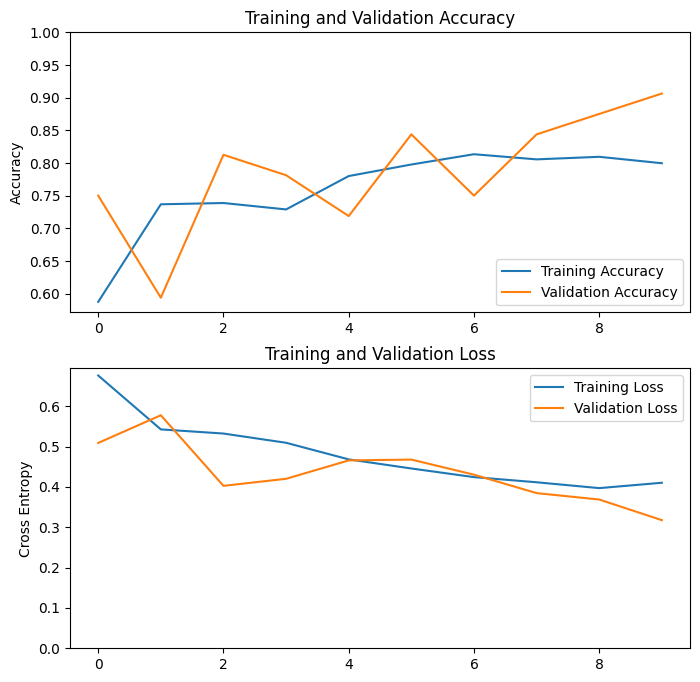

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 ________________

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 ________________

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Test the final Model

In [16]:
# Calculate the Loss and Accuracy on the Validation Data
val_loss, val_acc = model.evaluate(valid_generator)
print('val accuracy : ', val_acc)

2/2 [==============================] - 10s 5s/step - loss: 0.3359 - accuracy: 0.8644
val accuracy :  0.8644067645072937


In [17]:
# Calculate the Loss and Accuracy on the Test Data
test_loss, test_acc = model.evaluate(test_generator)
print('test accuracy : ', test_acc)

5/5 [==============================] - 26s 5s/step - loss: 0.3798 - accuracy: 0.7730
test accuracy :  0.7730496525764465


## Load the Model with Best Validation Accuracy

In [26]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model(os.path.join(base_dir + "CNN-Models", "model_05-0.94.h5"))

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'run', 1: 'walk'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=12)
        plt.ylabel('Probability', fontsize=12)
        plt.xticks(index, classes, fontsize=12, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()

    plot_bar_x()

#Checking the results

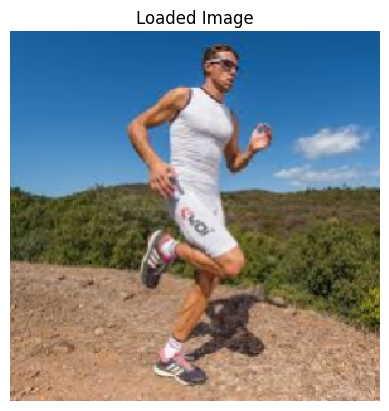

1/1 [==============================] - 2s 2s/step


Maximum Probability:  0.95032716
Classified: run 



-------------------Individual Probability--------------------------------

RUN : 95.03 %
WALK : 4.97 %


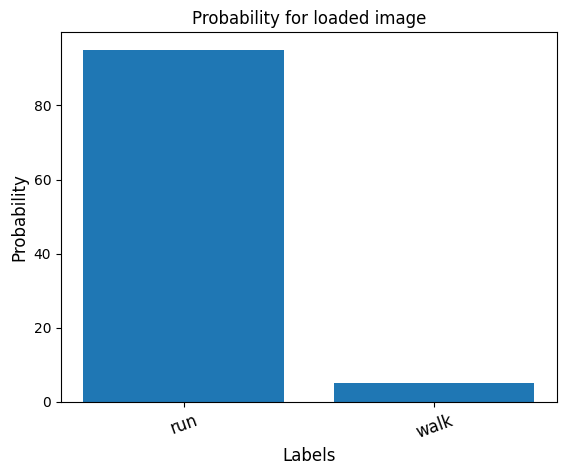

In [27]:
predict(os.path.join(test_data_dir, "test", "run", "run_9417fa3e.png"))

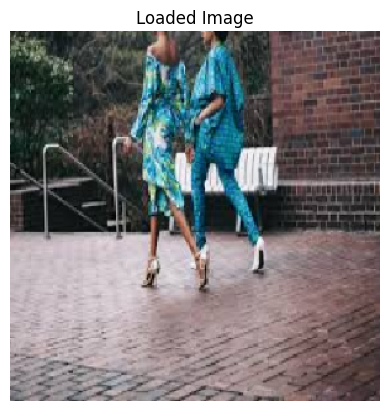

1/1 [==============================] - 0s 190ms/step


Maximum Probability:  0.7829583
Classified: walk 



-------------------Individual Probability--------------------------------

RUN : 21.7 %
WALK : 78.3 %


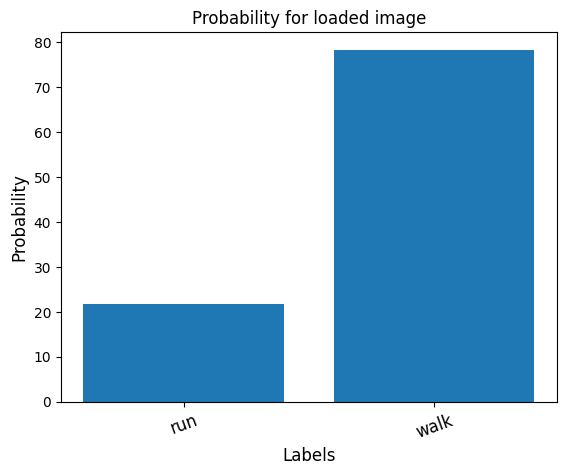

In [28]:
predict(os.path.join(test_data_dir, "test", "walk", "walk_54e056b6.png"))

#Conclusion

In conclusion, the "Walk or Run Image Prediction" project addresses a significant task in computer vision. Among the machine learning algorithms considered, Convolutional Neural Networks (CNNs) emerged as the most suitable choice, achieving an impressive accuracy of 81.56%. In comparison, the Random Forest Classifier with default parameters exhibited an accuracy of 47.51% and with tunned hyperparameters it gives as accuracy of 48.22% whereas Logistic Regression with default parameters approach achieved an accuracy of 48.9% and with tunned hyperparameters it gave accuracy of 58.15%. These results underscore the superior performance of CNNs in tackling the intricate task of accurately categorizing 'walking' and 'running' images.

#References


1. Simonyan, K., & Zisserman, A. (2014). Very Deep
Convolutional Networks for Large-Scale Image Recognition. arXiv preprint arXiv:1409.1556.

2. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the Inception Architecture for Computer Vision. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (pp. 2818-2826).

3. Chollet, F. (2017). Xception: Deep Learning with Depthwise Separable Convolutions. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (pp. 1251-1258).

4. Deng, J., Dong, W., Socher, R., Li, L. J., Li, K., & Fei-Fei, L. (2009). ImageNet: A large-scale hierarchical image database. In 2009 IEEE Conference on Computer Vision and Pattern Recognition (pp. 248-255). Available at: http://www.image-net.org/

5. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Vanderplas, J. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825-2830. Available at: https://scikit-learn.org/stable/documentation.html

6. [TensorFlow Documentation](https://www.tensorflow.org/api_docs)

7. [Keras Documentation](https://keras.io/api/)

8. [Kaggle](https://www.kaggle.com/)

9. [MIT 6.S191: Convolutional Neural Networks](https://www.youtube.com/watch?v=NmLK_WQBxB4)